In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate


from pygsp import graphs, filters, plotting
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm
import scipy
import matplotlib
import utils



import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

In [2]:
gcn_message = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [3]:
# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [4]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs.float())
        h = th.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 30 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.

In [5]:
# Build the target
genotype_gene_expression_present_df = pd.read_pickle("data/pickle/genotype_gene_expression_present_df.pkl")
phenotype_df = pd.read_pickle("data/pickle/phenotype.pkl")
y = phenotype_df.loc['X62'].dropna().astype('int64')
y = y[genotype_gene_expression_present_df.index]

In [6]:
# Build the relevant high variance signals
gene_expression_df = pd.read_pickle("data/pickle/gene_expression_df.pkl")
top_var = 30
top_var_gene = gene_expression_df.std().sort_values().tail(top_var)
signal = gene_expression_df[top_var_gene.index]

In [7]:
# What are the most present labels ?
y.value_counts()

1    25
4    17
3    16
2    14
Name: X62, dtype: int64

In [8]:
# Select only the mice that have label 1 or 4. We chose it because they are the most present
y_binary = y[(y.values == 1) | (y.values == 4)]

In [9]:
# Drop the rows with only nan values
sign = signal[signal.index.isin(y_binary.index)].dropna(how='all')

In [10]:
# Filter y_binary to take into account nan filtering
y_binary = y_binary[y_binary.index.isin(sign.index)]

In [11]:
# Are both index the same ?
(y_binary.index == sign.index).all()

True

In [12]:
# Transfrom to np.array
sign_np = sign.values

In [13]:
# Transfrom to np.array
sign_np = sign.values
y_b = y_binary.values

In [28]:
inputs = th.tensor(sign_np)

In [15]:
import random
# Select randomly which node to use as first labeled nodes 
# !!! idea: chose the best one based on graph properties !!!

one_node_labeled = np.random.choice(np.where(y_b == 1)[0])
four_node_labeled = np.random.choice(np.where(y_b == 4)[0])
print(one_node_labeled, four_node_labeled)
print("y_b[one_node_labeled]: %i, y_b[four_node_labeled]: %i" % (y_b[one_node_labeled], y_b[four_node_labeled]))

13 0
y_b[one_node_labeled]: 1, y_b[four_node_labeled]: 4


In [16]:
# Assign the labels both randomely selected nodes
labeled_nodes = th.tensor([one_node_labeled, four_node_labeled]) ## 
labels = th.tensor([0, 1])

In [17]:
# Build a graph adjacency for the subsample and mice labeled as 1 and 4
genotype_df = pd.read_pickle('data/pickle/genotype_df.pkl')
adj = utils.build_adj_from_strain(genotype_df, sign.index, 'cosine', 70, 0.273)

/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


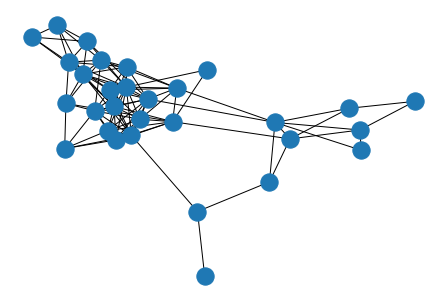

In [18]:
nx.draw(nx.from_numpy_array(adj))

In [19]:
utils.graph_basic_stats(nx.from_numpy_array(adj))

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  30    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 106    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │  24.37 │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │   7.07 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.49 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   5    │
╘═════════════════════════════════════════════════╧════════╛


In [20]:
G = DGLGraph(adj)

In [21]:
net = GCN(sign_np.shape[1], 2, 2)

In [23]:
optimizer = th.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7660
Epoch 1 | Loss: 0.7624
Epoch 2 | Loss: 0.7588
Epoch 3 | Loss: 0.7554
Epoch 4 | Loss: 0.7520
Epoch 5 | Loss: 0.7487
Epoch 6 | Loss: 0.7456
Epoch 7 | Loss: 0.7425
Epoch 8 | Loss: 0.7395
Epoch 9 | Loss: 0.7367
Epoch 10 | Loss: 0.7339
Epoch 11 | Loss: 0.7312
Epoch 12 | Loss: 0.7287
Epoch 13 | Loss: 0.7262
Epoch 14 | Loss: 0.7238
Epoch 15 | Loss: 0.7216
Epoch 16 | Loss: 0.7195
Epoch 17 | Loss: 0.7174
Epoch 18 | Loss: 0.7155
Epoch 19 | Loss: 0.7136
Epoch 20 | Loss: 0.7119
Epoch 21 | Loss: 0.7103
Epoch 22 | Loss: 0.7087
Epoch 23 | Loss: 0.7073
Epoch 24 | Loss: 0.7059
Epoch 25 | Loss: 0.7047
Epoch 26 | Loss: 0.7035
Epoch 27 | Loss: 0.7024
Epoch 28 | Loss: 0.7014
Epoch 29 | Loss: 0.7005


/Users/Raphael/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


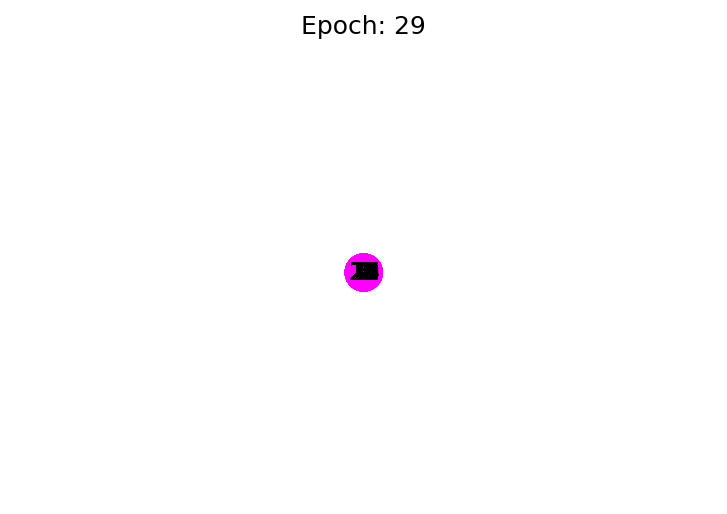

In [24]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

nx_G = G.to_networkx().to_undirected()

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(30):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(29)  # draw the prediction of the first epoch
# plt.close()

In [ ]:
from IPython.display import HTML
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_jshtml())

In [ ]:
# TRAINING

def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)


In [25]:
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 1000
p_dropout = 0.8

In [29]:
features = th.tensor(sign_np)
labels

tensor([0, 1])

In [ ]:
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))